# Variational Autoencoder Beispiel


## Dieses Beispiel wird mit diesen Bibliotheken ausgeführt:

**REF: https://keras.io/examples/generative/vae/**

- pip install numpy==1.26.4
- pip install tensorflow==2.17.0
- pip install matplotlib==3.9.1


## [1] Importieten die benötigen Bibliotehken

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, backend as K
import matplotlib.pyplot as plt


## [2] Datenbereiten

- In diesem Beispspiel wird MNIST Dataset verwendet


```python
# [A] Laden des Datensatzes und Zusammenstellung der Test und Trainingsbeispielen in einer Variable
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
```

```python
# [B] Normalisierung ddes Datensatzes
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
```

\begin{equation}
\text{normalisierte Sample} = \frac{\text{originale Sample}}{255}
\end{equation}

In [2]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

## [3] Vorbereitung von der Encoder

```python
# [A] Encoder Sichten Definieren
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
```

```python
# [B] Definieren die Schichten, die das "Mean" und die "Variance" berechnen.
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
```
**Note: Wir müssen berücksichtigen, dass die Schicht uns den Logarithmus der Variance geben werden, wie in die Gleichung gezeigt**
$$
\log(\sigma^2)
$$



In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)


## [4] Sampling und Reparameterization Trick

**Reparameterization Trick**
$$
z = \mu + \sigma \cdot \epsilon
$$

**NOTE: Wir haben bereits das "Mean" und  Logarithmus der "Variance" berechnet**

```python
# [A] Epsilon berechnen
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
```

**NOTE:hier berechnen wir epsilon aus der gaussian Verteilung**
$$
\epsilon \sim N(0,1)
$$

```python
# [B] Standert Deviation berechnen 
        tf.exp(0.5 * z_log_var) 
```

**NOTE:Da wir den Logarithmus der quadrierten Variance haben, multiplizieren wir mit 0.5, um den Logarithmus des Standard Deviation zu erhalten. Anschließend wenden wir die Exponentialfunktion auf den Logarithmus des Standard Deviationn an, um die es zu berechnen, wie in Gleichungen Gezeigt**

$$
        \log(\sigma) = 0.5 \log(\sigma^2) = 2\log(\sigma)
$$


$$
        \sigma = e^{\log(\sigma)}
$$

**Jetzt haben wir alles**

```python
# [C] Sampling

        z = Sampling()([z_mean, z_log_var])
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
```

$$
z = \mu + \sigma \cdot \epsilon
$$

In [4]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    

z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")



## [5] Vorbereitung von der Decoder

```python
# [A] Decoder Sichten Definieren
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
```

**NOTE:Hier verwenden wir Deconolutional Schichten**

In [5]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

## [6] Model Konfigurationen (Art der Optimizer , epochs, Batch .....)

In [6]:

optimizer = keras.optimizers.Adam()
batch_size = 128
epochs = 10

# Setup metric trackers
total_loss_tracker = keras.metrics.Mean(name="total_loss")
reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
total_loss_values = []

## [7] TrainingsProzess

$$
\text{ELBO} = \mathbb{E}_{q(z|x)}[\log p(x|z)] - \text{KL}(q(z|x) \| p(z))
$$

$$
\text{total loss} = -\text{ELBO} = \text{reconstruction loss} + \text{KL loss}
$$

```python
# [A] Reconstruction LOSS = - CROSS ENTROPY 
  reconstruction_loss = tf.reduce_sum(
                keras.losses.binary_crossentropy(x_batch_train, reconstruction), axis=(1, 2)
            )
```

```python
# [B] KL LOSS berechnen
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
```

**NOTE:Hier wird KL vereinfacht**

In [7]:

for epoch in range(epochs):
    print("Start of epoch %d" % (epoch,))
    for step in range(len(mnist_digits) // batch_size):
        x_batch_train = mnist_digits[step * batch_size: (step + 1) * batch_size]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(x_batch_train)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_sum(
                keras.losses.binary_crossentropy(x_batch_train, reconstruction), axis=(1, 2)
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

        grads = tape.gradient(total_loss, encoder.trainable_weights + decoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, encoder.trainable_weights + decoder.trainable_weights))

        total_loss_tracker.update_state(total_loss)
        reconstruction_loss_tracker.update_state(tf.reduce_mean(reconstruction_loss))
        kl_loss_tracker.update_state(tf.reduce_mean(kl_loss))

        if step % 100 == 0:
            print("step %d: mean loss = %.4f" % (step, total_loss_tracker.result()))
        total_loss_values.append(total_loss_tracker.result().numpy())


Start of epoch 0
step 0: mean loss = 543.4911
step 100: mean loss = 281.1721
step 200: mean loss = 243.6785
step 300: mean loss = 228.6562
step 400: mean loss = 220.5257
step 500: mean loss = 214.7022
Start of epoch 1
step 0: mean loss = 213.0990
step 100: mean loss = 209.8366
step 200: mean loss = 207.4588
step 300: mean loss = 205.2703
step 400: mean loss = 203.2464
step 500: mean loss = 200.7615
Start of epoch 2
step 0: mean loss = 199.8527
step 100: mean loss = 197.7713
step 200: mean loss = 195.9417
step 300: mean loss = 194.1558
step 400: mean loss = 192.5794
step 500: mean loss = 191.0031
Start of epoch 3
step 0: mean loss = 190.4360
step 100: mean loss = 189.1534
step 200: mean loss = 188.0333
step 300: mean loss = 186.9209
step 400: mean loss = 185.9077
step 500: mean loss = 184.8528
Start of epoch 4
step 0: mean loss = 184.4680
step 100: mean loss = 183.6023
step 200: mean loss = 182.8367
step 300: mean loss = 182.0447
step 400: mean loss = 181.3186
step 500: mean loss = 180.

## [8] Darstellung von Loss jede Eboch


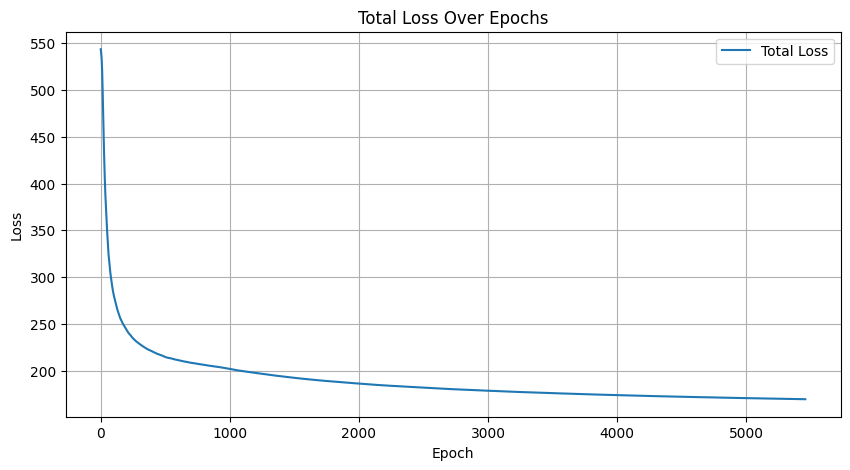

In [10]:

def plot_loss(total_loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(total_loss_values, label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Total Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(total_loss_values)

## [9] Darstellung des Latent Raums

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━

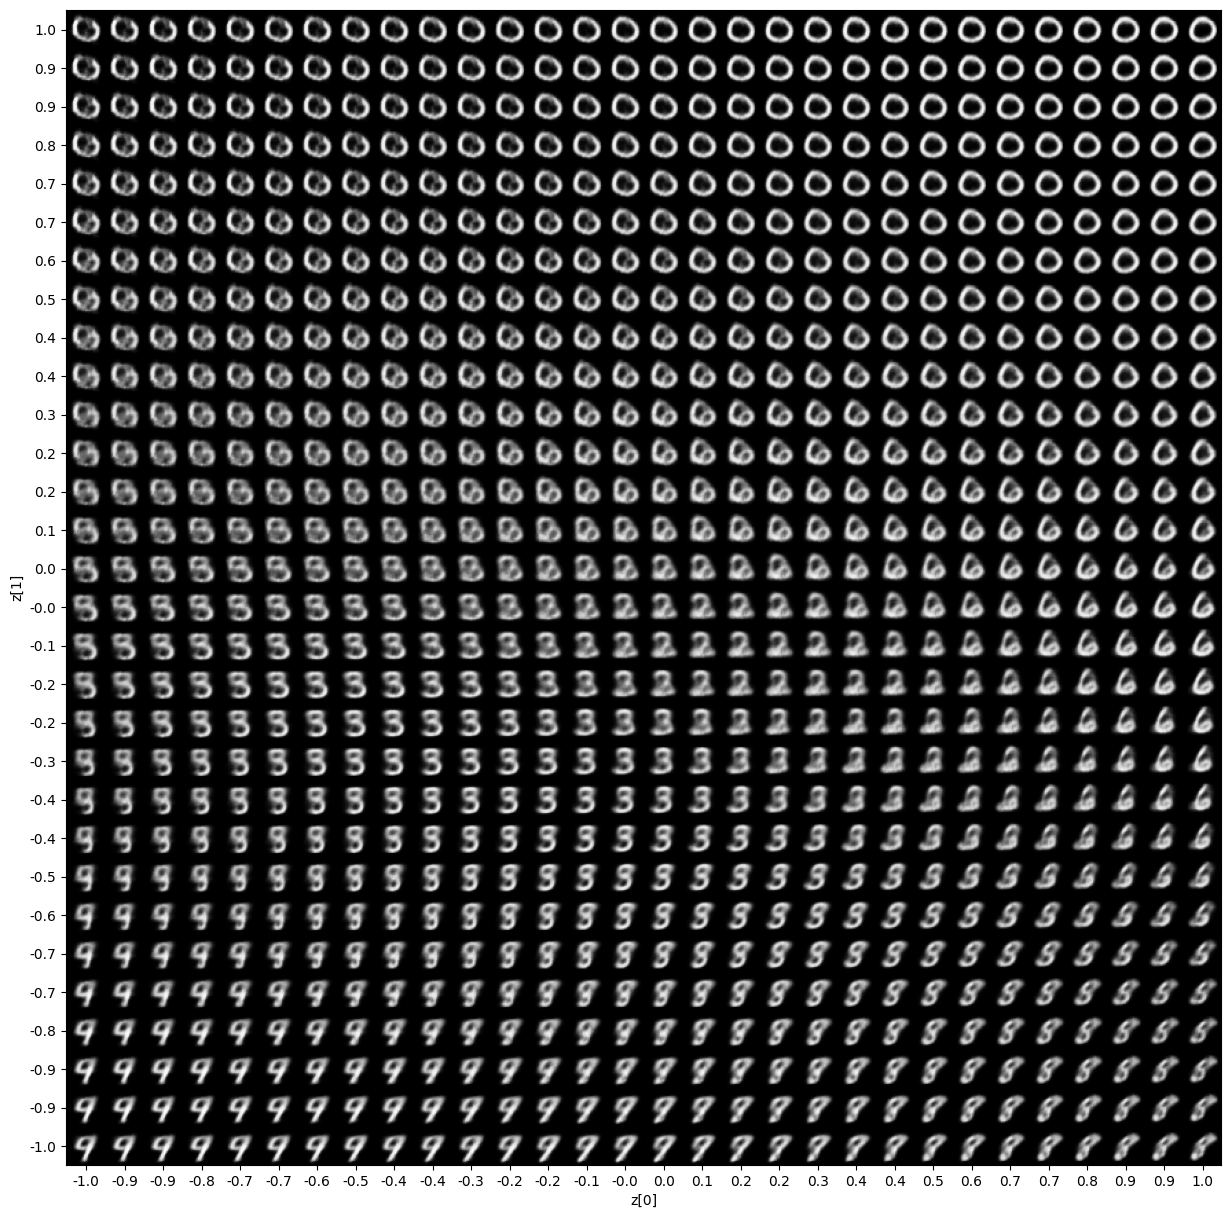

In [11]:
def plot_latent_space(encoder, decoder, n=30, figsize=15):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(encoder, decoder)